# Example 3 - Convolutional Neural Network

This builds on examples 1 and 2 by creating a new, deeper architecture for the neural network. Instead of computing linear algebra directly in `numpy`, this example uses Theano's higher level abstractions to simplify the code and also obtain a speed boost (particularly on machines that have a compatible GPU).

In [27]:
import gzip
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import theano
import theano.tensor as T
from theano.tensor import shared_randomstreams, tanh
from theano.tensor.nnet import conv, softmax, sigmoid
from theano.tensor.signal import downsample

%matplotlib inline
matplotlib.rc('font', family='Arial')

Configure Theano to use GPU. Delete and/or skip this block if you wish to use CPU instead.

In [4]:
try:
    theano.config.device = 'gpu'
except:
    pass
theano.config.floatX = 'float32'

Define some helper functions.

In [144]:
def dropout_layer(layer, dropout_prob):
    srng = shared_randomstreams.RandomStreams(
        np.random.RandomState(0).randint(999999)
    )
    mask = srng.binomial(n=1, p=1-dropout_prob, size=layer.shape)
    return layer * T.cast(mask, theano.config.floatX)

def linear(z):
    return z

def load_data():
    with gzip.open('./mnist.pkl.gz') as mnist_file:
        data = pickle.load(mnist_file, encoding='bytes')
    
    def shared(data):
        shared_x = theano.shared(
            np.asarray(data[0], dtype=theano.config.floatX), borrow=True
        )
        shared_y = theano.shared(
            np.asarray(data[1], dtype='int32'), borrow=True
        )
        return shared_x, shared_y

    return shared(data[0]), shared(data[1]), shared(data[2])

def one_hot(len_, j):
    vec = np.zeros((len_, 1))
    vec[j] = 1
    return vec

def relu(z):
    return T.maximum(0, z)

def size(data):
    return data[0].get_value(borrow=True).shape[0]

Define the various types of layers used in this deep network.

In [22]:
class ConvPoolLayer:
    def __init__(self, filter_shape, image_shape, poolsize=(2,2),
                 activation_fn=sigmoid):
        self.filter_shape = filter_shape
        self.image_shape = image_shape
        self.poolsize = poolsize
        self.activation_fn = activation_fn
        
        n_out = (
            filter_shape[0] * 
            np.prod(filter_shape[2:]) / 
            np.prod(poolsize)
        )
        
        self.weights = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0, 
                    scale=np.sqrt(1 / n_out),
                    size=filter_shape
                ),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        self.biases = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0, 
                    scale=1,
                    size=(filter_shape[0],)
                ),
                dtype=theano.config.floatX
            ),
            borrow=True
        )
        
        self.params = [self.weights, self.biases]

    def set_input(self, input_, input_dropout, mini_batch_size):
        self.input = input_.reshape(self.image_shape)
        conv_out = conv.conv2d(
            input=self.input,
            filters=self.weights,
            filter_shape=self.filter_shape,
            image_shape=self.image_shape
        )
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=self.poolsize,
            ignore_border=True
        )
        self.output = self.activation_fn(
            pooled_out + self.biases.dimshuffle('x', 0, 'x', 'x')
        )
        self.output_dropout = self.output
        
        

class FullyConnectedLayer:
    def __init__(self, n_in, n_out, activation_fn=sigmoid, dropout_prob=0):
        self.n_in = n_in
        self.n_out = n_out
        self.activation_fn = activation_fn
        self.dropout_prob = dropout_prob
        
        self.weights = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0, scale=np.sqrt(1/n_out), size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            ),
            name='weights', borrow=True
        )
        
        self.biases = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=1, size=(n_out,)),
                dtype=theano.config.floatX
            ),
            name='biases',
            borrow=True
        )
        
        self.params = [self.weights, self.biases]
    
    def set_input(self, input_, input_dropout, mini_batch_size):
        self.input = input_.reshape((mini_batch_size, self.n_in))
        self.output = self.activation_fn(
            (1 - self.dropout_prob) * T.dot(self.input, self.weights) + 
            self.biases
        )
        self.y_out = T.argmax(self.output, axis=1)
        self.input_dropout = dropout_layer(
            input_dropout.reshape((mini_batch_size, self.n_in)),
            self.dropout_prob
        )
        self.output_dropout = self.activation_fn(
            T.dot(self.input_dropout, self.weights) + self.biases
        )
    
    def accuracy(self, y):
        return T.mean(T.eq(y, self.y_out))


class SoftmaxLayer:
    def __init__(self, n_in, n_out, dropout_prob=0):
        self.n_in = n_in
        self.n_out = n_out
        self.dropout_prob = dropout_prob

        self.weights = theano.shared(
            np.zeros((n_in, n_out), dtype=theano.config.floatX),
            name='weights',
            borrow=True
        )
        
        self.biases = theano.shared(
            np.zeros((n_out,), dtype=theano.config.floatX),
            name='biases',
            borrow=True
        )
        
        self.params = [self.weights, self.biases]
    
    def set_input(self, input_, input_dropout, mini_batch_size):
        self.input = input_.reshape((mini_batch_size, self.n_in))
        self.output = softmax(
            (1 - self.dropout_prob) * T.dot(self.input, self.weights) +
            self.biases
        )
        self.y_out = T.argmax(self.output, axis=1)
        self.input_dropout = dropout_layer(
            input_dropout.reshape((mini_batch_size, self.n_in)),
            self.dropout_prob
        )
        self.output_dropout = softmax(
            T.dot(self.input_dropout, self.weights) + self.biases
        )
    
    def cost(self, net):
        return -T.mean(
            T.log(self.output_dropout)[T.arange(net.y.shape[0]), net.y]
        )

    def accuracy(self, y):
        return T.mean(T.eq(y, self.y_out))

Define the neural network class.

In [108]:
class Network:
    def __init__(self, layers, mini_batch_size):
        self.layers = layers
        self.mini_batch_size = mini_batch_size
        self.params = [p for layer in self.layers for p in layer.params]
        self.x = T.matrix('x')
        self.y = T.ivector('y')
        self.layers[0].set_input(self.x, self.x, self.mini_batch_size)
        
        for l in range(1, len(self.layers)):
            prev_layer = self.layers[l - 1]
            layer = self.layers[l]
            layer.set_input(
                prev_layer.output, 
                prev_layer.output_dropout,
                self.mini_batch_size
            )
        
        self.output = self.layers[-1].output
        self.output_dropout = self.layers[-1].output_dropout

    def sgd(self, train_data, epochs, mini_batch_size, learning_rate,
            eval_data, test_data, regularization=0):

        train_x, train_y = train_data
        validation_x, validation_y = validation_data
        test_x, test_y = test_data
        
        num_train_batches = size(train_data) // mini_batch_size
        num_validation_batches = size(validation_data) // mini_batch_size
        num_test_batches = size(test_data) // mini_batch_size
        
        l2_norm_squared = sum((l.weights**2).sum() for l in self.layers)

        cost = (
            self.layers[-1].cost(self) + 
            0.5 * regularization * l2_norm_squared / num_train_batches
        )
        
        grads = T.grad(cost, self.params)
        updates = list()
        
        for param, grad in zip(self.params, grads):
            updates.append((param, param - learning_rate * grad))
            
        i = T.lscalar()
        mb = self.mini_batch_size

        train_mb = theano.function(
            [i],
            cost,
            updates=updates,
            givens={
                self.x: train_x[i * mb : (i+1) * mb],
                self.y: train_y[i * mb : (i+1) * mb],
            }
        )

        validate_mb_accuracy = theano.function(
            [i],
            self.layers[-1].accuracy(self.y),
            givens={
                self.x: validation_x[i * mb : (i+1) * mb],
                self.y: validation_y[i * mb : (i+1) * mb],
            }
        )

        test_mb_accuracy = theano.function(
            [i],
            self.layers[-1].accuracy(self.y),
            givens={
                self.x: test_x[i * mb : (i+1) * mb],
                self.y: test_y[i * mb : (i+1) * mb],
            }
        )

        self.test_mb_predictions = theano.function(
            [i],
            self.layers[-1].y_out,
            givens={
                self.x: test_x[i * mb : (i+1) * mb],
                self.y: test_y[i * mb : (i+1) * mb],
            }
        )
        
        best_validation_accuracy = 0
        best_iteration = 0
        best_iter_test_accuracy = 0
        
        for epoch in range(epochs):
            for minibatch_index in range(num_train_batches):
                iteration = num_train_batches * epoch + minibatch_index
                if iteration % 1000 == 0:
                    print('Training mini-batch #{}'.format(iteration))
                cost_ij = train_mb(minibatch_index)
                if (iteration + 1) % num_train_batches == 0:
                    validation_accuracy = np.mean([
                        validate_mb_accuracy(b) for b 
                        in range(num_validation_batches)
                    ])
                    print('Epoch {}: validation accuracy {:0.3f}%'
                         .format(epoch, validation_accuracy))
                    if validation_accuracy >= best_validation_accuracy:
                        print("New best validation accuracy!")
                        best_validation_accuracy = validation_accuracy
                        best_iteration = iteration
                        if test_data:
                            best_iter_test_accuracy = np.mean([
                                test_mb_accuracy(b) for b
                                in range(num_test_batches)
                            ])
                            print('Test accuracy is {:0.3f}'
                                 .format(best_iter_test_accuracy))
        
        print('Finished training.')
        print('Best validation accuracy was {:0.3f} at iteration={}'
             .format(best_validation_accuracy, best_iteration))
        print('Test accuracy was {:0.3f} in that iteration'
             .format(best_iter_test_accuracy))

Load data.

In [145]:
train_data, validation_data, test_data = load_data()

Create a network.

In [61]:
MINI_BATCH_SIZE = 10

net_layers = [
    ConvPoolLayer(
        image_shape=(MINI_BATCH_SIZE, 1, 28, 28),
        filter_shape=(20, 1, 5, 5),
        poolsize=(2, 2),
        activation_fn=relu
    ),
    FullyConnectedLayer(n_in=20*12*12, n_out=100),
    SoftmaxLayer(n_in=100, n_out=10)
]

net = Network(net_layers, mini_batch_size)

Train the network.

In [62]:
net.sgd(
    train_data,
    epochs=60,
    mini_batch_size=MINI_BATCH_SIZE,
    learning_rate=0.1,
    eval_data=validation_data,
    test_data=test_data
)

Training mini-batch #0
Training mini-batch #1000
Training mini-batch #2000
Training mini-batch #3000
Training mini-batch #4000
Epoch 0: validation accuracy 0.966
New best validation accuracy!
Test accuracy is 0.963
Training mini-batch #5000
Training mini-batch #6000
Training mini-batch #7000
Training mini-batch #8000
Training mini-batch #9000
Epoch 1: validation accuracy 0.978
New best validation accuracy!
Test accuracy is 0.977
Training mini-batch #10000
Training mini-batch #11000
Training mini-batch #12000
Training mini-batch #13000
Training mini-batch #14000
Epoch 2: validation accuracy 0.982
New best validation accuracy!
Test accuracy is 0.983
Training mini-batch #15000
Training mini-batch #16000
Training mini-batch #17000
Training mini-batch #18000
Training mini-batch #19000
Epoch 3: validation accuracy 0.984
New best validation accuracy!
Test accuracy is 0.984
Training mini-batch #20000
Training mini-batch #21000
Training mini-batch #22000
Training mini-batch #23000
Training mini

Show two random minibatches from the test set and the neural network's predicted labels. (Execute this cell again to pick a new set of random examples.) The actual label `y` and predicted label `ŷ` are shown above each example.

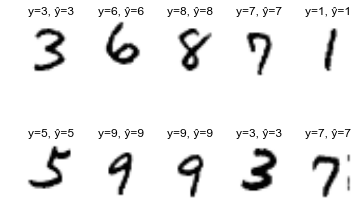

In [161]:
rows, cols = 2, 5
test_batches = size(test_data) //  MINI_BATCH_SIZE
batch_num = random.randrange(0, test_batches)
predictions = net.test_mb_predictions(batch_num)

for i, y_hat in enumerate(predictions):
    row = batch_num * MINI_BATCH_SIZE + i
    x = test_data[0].get_value()[row]
    y = test_data[1].get_value()[row]
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    plt.title('y={}, ŷ={}'.format(y, y_hat))